In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import scipy.stats
import statsmodels.formula.api as smf


from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [10, 5]

In [ ]:
data = []
for f in glob("data/*"):
    participant, condition, trial = map(int,
            os.path.basename(f).split('.')[0].split('_'))
    d = pd.read_csv(f, delimiter='\t', names="t steering condition".split())
    assert (d['condition'] == condition).all()
    d['participant'] = participant
    d['trial'] = trial
    data.append(d)

data = pd.concat(data)
data.sort_values(['participant', 'trial', 't'])

def reaction_time(d):
    return d

reaction_time = data.groupby(['participant', 'trial', 'condition']).apply(
        lambda d: d[d.steering != 0].t.min()
        ).reset_index(name='rt')

In [3]:
is_distracted = lambda c: c in (3, 4)
is_visual = lambda c: c in (2, 4)
modality = lambda c: ["Auditory", "Visual"][is_visual(c)]
distraction = lambda c: ["Non-distracted", "Distracted"][is_distracted(c)]
condition_label = lambda c: f"{modality(c)}, {distraction(c)}"

reaction_time['is_distracted'] = reaction_time.condition.isin((3, 4))
reaction_time['is_visual'] = reaction_time.condition.isin((2, 4))
reaction_time['lrt'] = np.sqrt(reaction_time['rt'])
reaction_time['x'] = reaction_time['rt']

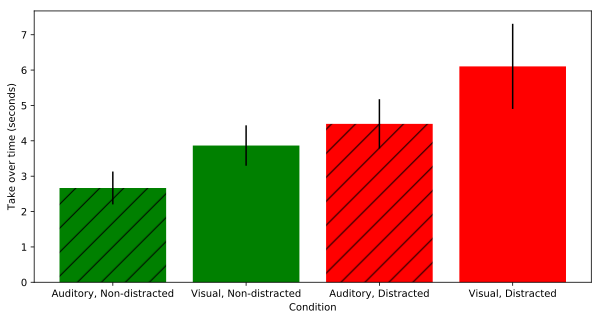

In [25]:
rt_subj_means = reaction_time.groupby(['participant', 'condition']).mean()
conds = []
condlabels = []
for condition, cd in rt_subj_means.groupby(['condition']):
    plt.bar(condition, np.mean(cd['rt']), yerr=np.std(cd['rt']),
            color=['green', 'red'][is_distracted(condition)],
           hatch=['/', ''][is_visual(condition)])
    conds.append(condition)
    condlabels.append(condition_label(condition))
plt.gca().set_xticks(conds);
plt.gca().set_xticklabels(condlabels)
plt.xlabel("Condition")
plt.ylabel("Take over time (seconds)")

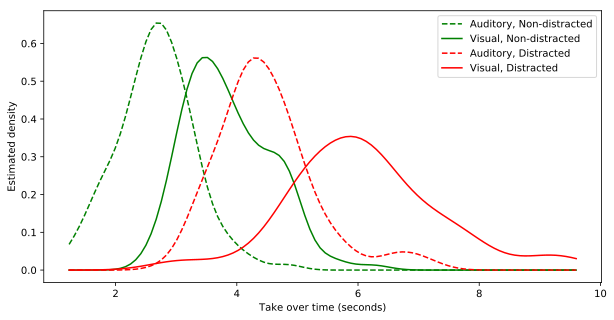

In [31]:
rng = np.linspace(np.min(reaction_time['x']), np.max(reaction_time['x']), 100)
for c, d in reaction_time.groupby('condition'):
    color = ['green', 'red'][is_distracted(c)]
    ls = ['dashed', 'solid'][is_visual(c)]
    rt = d['x']
    est = scipy.stats.gaussian_kde(rt)
    plt.plot(rng, est(rng),
            color=color, ls=ls,
            label=condition_label(c)
            )
    #plt.hist(rt, histtype='step', bins='scott',
    #        color=color, ls=ls,
    #        label=f"{modality(c)}, {distraction(c)}")

plt.legend()
plt.xlabel('Take over time (seconds)')
plt.ylabel("Estimated density");

In [32]:
r.library('lme4')
r.assign('data', reaction_time)
rmodel = r('glmer(x ~ is_visual*is_distracted + trial + (1|participant), data=data, family = inverse.gaussian(link = "identity"))')
print(r.summary(rmodel))

/usr/lib/python3/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: inverse.gaussian  ( identity )
Formula: x ~ is_visual * is_distracted + trial + (1 | participant)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  1118.5   1147.7   -552.2   1104.5      473 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5340 -0.6691 -0.1243  0.5055  3.8540 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.050912 0.22564 
 Residual                0.009018 0.09496 
Number of obs: 480, groups:  participant, 20

Fixed effects:
                                Estimate Std. Error t value Pr(>|z|)    
(Intercept)                      2.51037    0.12804  19.607  < 2e-16 ***
is_visualTRUE                    1.29293    0.07276  17.771  < 2e-16 ***
is_distractedTRUE                1.95960    0.08832  22.187  < 2e-16 ***
trial                            0.04390    0.01629   2.695  0.00703 ** 
is_visualTRUE:is_d